In [1]:
from astropy.io import fits
# documentation: see https://docs.astropy.org/en/stable/io/fits/
import matplotlib.pyplot as plt
import numpy as np
hdu_list = fits.open('specgrid.fits')
logwave = hdu_list['LOGWAVE'].data
flux = hdu_list['FLUX'].data

In [2]:
flux.shape
# flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]
# there are 9713 galaxies 

(9713, 4001)

In [3]:
logwave.shape
# wavelength 

(4001,)

Text(0.5, 0, 'wavelength [$A$]')

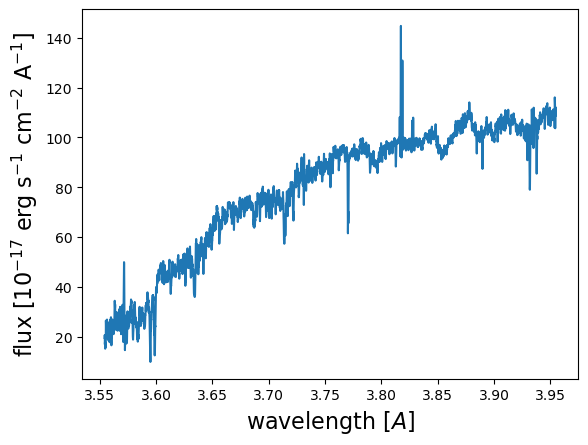

In [4]:
plt.plot(logwave, flux[0, :])
plt.ylabel('flux [$10^{−17}$ erg s$^{−1}$ cm$^{−2}$ A$^{-1}$]', fontsize = 16)
plt.xlabel('wavelength [$A$]', fontsize = 16)

# hint: look for Lyman series (emission lines of hydrogen)

In [5]:
# find normalization over wavelength for each galaxy
flux_sum = np.sum(flux, axis = 1)

In [6]:
flux_sum.shape

(9713,)

In [7]:
flux_normalized = flux/np.tile(flux_sum, (np.shape(flux)[1], 1)).T

(0.0, 2.0)

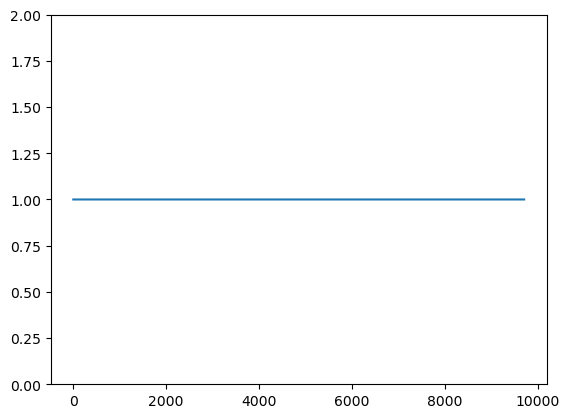

In [8]:
plt.plot(np.sum(flux_normalized, axis = 1))
plt.ylim(0,2)

In [9]:
# subtract off mean
means_normalized = np.mean(flux_normalized, axis=1)

In [10]:
means_normalized

array([0.00024994, 0.00024994, 0.00024994, ..., 0.00024994, 0.00024994,
       0.00024994], dtype=float32)

In [11]:
flux_normalized_0_mean = flux_normalized-np.tile(means_normalized, (np.shape(flux)[1], 1)).T

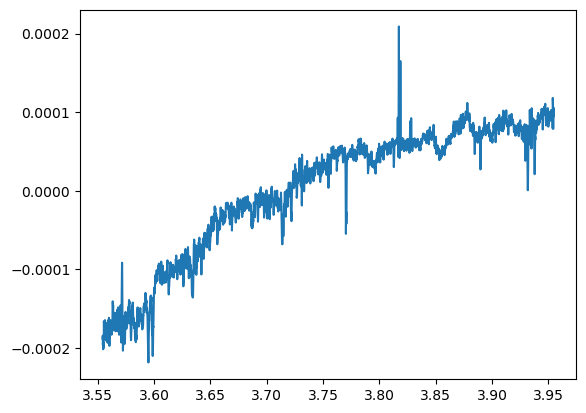

In [12]:
plt.plot(logwave, flux_normalized_0_mean[0,:])

In [13]:
# perform the PCA: calculate C

C = flux_normalized_0_mean.T@flux_normalized_0_mean
#C = np.cov(flux_normalized_0_mean, rowvar = False)


In [14]:
C.shape

(4001, 4001)

In [15]:
# functions for the momentum space RG

def eigmom(pmat):
    """
    Calculate the eigenvectors in preperation for momentum space RG
    -----------------------------------------------------
    Inputs:
    pmat: the activity array of all cells' spike trains. 
          shape: (N, xmax*dt*loop)
    -------------------------------------------------------------
    Output: array of eigenvectors. Each eigenvector is a column in this array. 
            shape: (N,N)
    """
    #corr=np.cov(pmat)
    corr = pmat@pmat.T
    #np.fill_diagonal(corr, 0.)
    #corr[np.where(np.isnan(corr)==True)]=0.
    eigs=np.linalg.eig(corr) #calculate eigenvectors and values of original 
    #print(eigs[0].shape)
    # activity
    arg=np.argsort(eigs[0])[::-1] #get indices for sorted eigenvalues
    eigvec=eigs[1][:,arg] #sort eigenvectors
    return eigvec


def fluc(pmat):
    """
    Calculate fluctuations in preparation for projection onto chosen 
    eigenvectors for momentum space RG
    -----------------------------------------------------------
    Inputs:
    pmat: activity matrix holding all cells' spike trains
    ------------------------------------------------------------
    Output: array holding fluctuations away from mean for each cell
    """
    return pmat - np.reshape(np.mean(pmat, axis=1), (pmat.shape[0],1)) 

def RGmom(l, r):
    """
    Perform momentum space RG step
    --------------------------------------------------------------------------------------
    Inputs:
    l: total number of eigenvectors/l = number of eigenvectors I will 
        project fluctuations onto. shape:scalar
    a: object
    --------------------------------------------------------------------------------------
    Output: RG transformed activity array. shape: (N/l, xmax*dt*loop)
    """
    eigvector = eigmom(r)
    eigvec=eigvector[:,:int(eigvector.shape[1]/l)] #sort eigenvectors, cut out some
    ppmat=np.dot(eigvec,np.dot(eigvec.T,r))
    #print(ppmat.shape)
    #project fluctuations onto chosen eigenvectors
    return ppmat

In [16]:
r = flux_normalized_0_mean 
r_subset = r[:1000, :]
logwave_subset = logwave
C = r_subset.T@r_subset

In [17]:
r_subset.shape

(1000, 4001)

In [18]:
logwave_subset.shape

(4001,)

In [19]:
r_subset.shape

(1000, 4001)

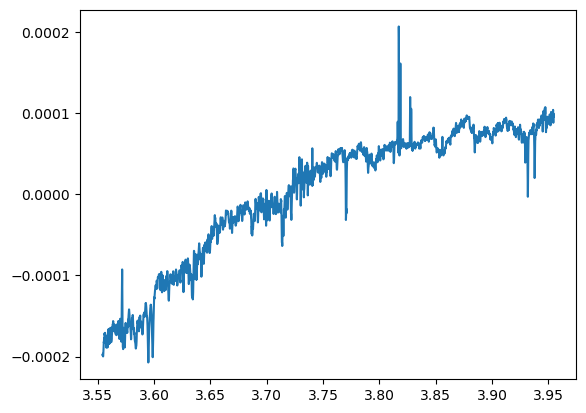

In [20]:
plt.plot(logwave_subset, RGmom(100,r_subset)[0,:])

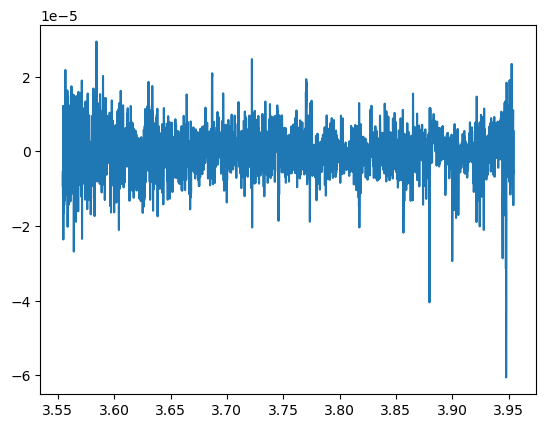

In [21]:
plt.plot(logwave_subset, r_subset[1,:]-RGmom(10,r_subset)[1,:])

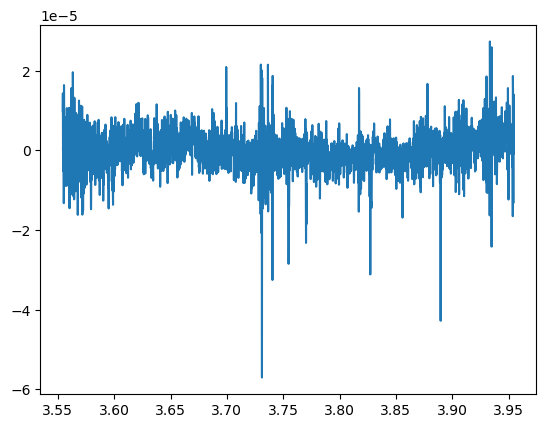

In [22]:
plt.plot(logwave_subset, r_subset[0,:]-RGmom(100,r_subset)[0,:])

In [23]:
eigvals, eigvecs = np.linalg.eig(C)
sort_idx = np.argsort(eigvals)[::-1]

In [24]:
eigvecs = eigvecs[:, sort_idx]
eigvals = eigvals[sort_idx]

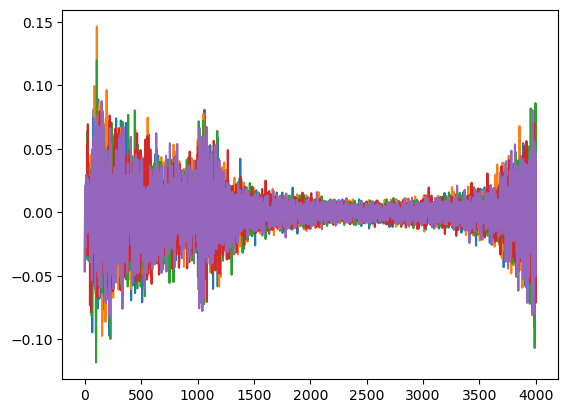

In [25]:
for i in range(5):
    plt.plot(eigvecs[i])

In [26]:
U, S, Vh = np.linalg.svd(r_subset, full_matrices=False)
# rows of Vh are eigenvectors
eigvecs_svd = Vh.T
eigvals_svd = S**2
svd_sort = np.argsort(eigvals_svd)[::-1]
eigvecs_svd = eigvecs_svd[:,svd_sort]
eigvals_svd = eigvals_svd[svd_sort]

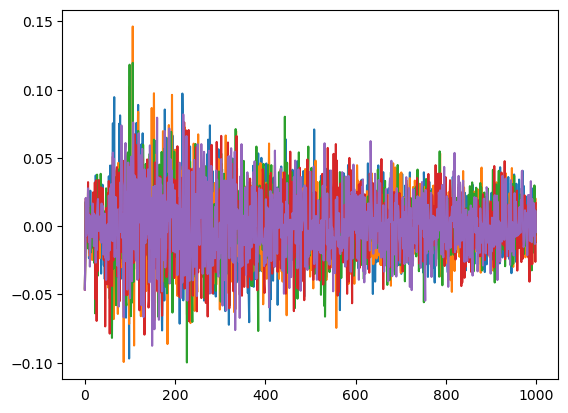

In [27]:
for i in range(5):
    plt.plot(eigvecs_svd[i])

In [28]:
eigvecs.shape

(4001, 4001)

In [29]:
eigvecs_svd.shape

(4001, 1000)

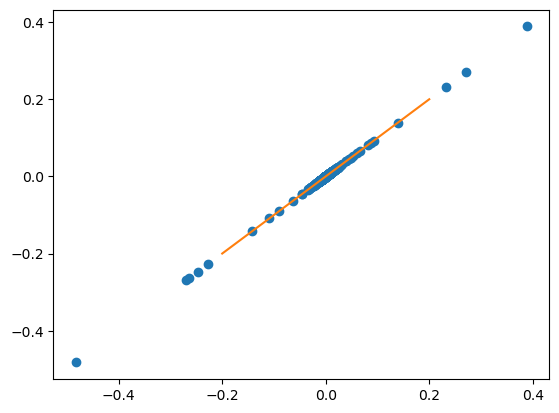

In [30]:
plt.plot(eigvecs[:,10], eigvecs_svd[:,10], 'o')
plt.plot(np.linspace(-0.2, 0.2), np.linspace(-0.2, 0.2))

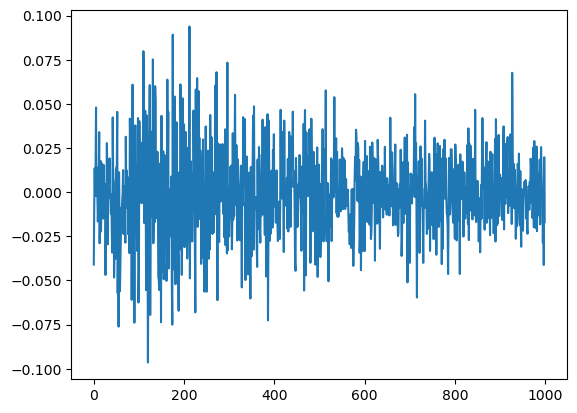

In [31]:
plt.plot(eigvecs_svd[10])

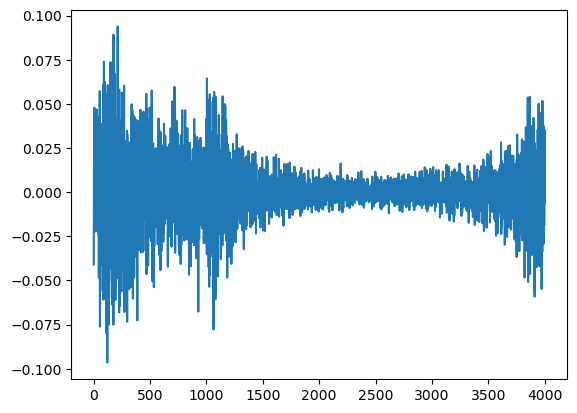

In [32]:
plt.plot(eigvecs[10])

In [33]:
eigvals[0]/eigvals[-1]

-67506820.0

In [34]:
eigvals_svd[0]/eigvals_svd[-1]

1639338.6

[[<matplotlib.lines.Line2D at 0x7f6ffa354c40>],

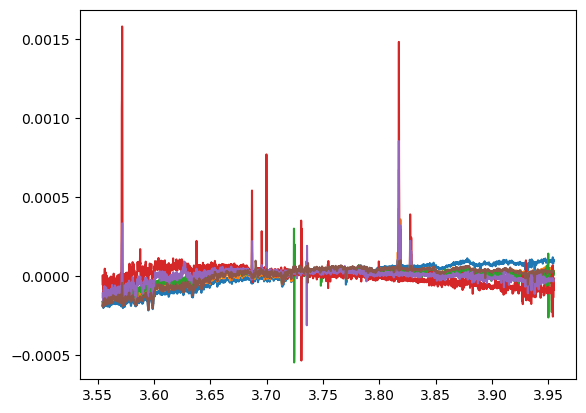

In [35]:
[plt.plot(logwave, r_subset[i, :]) for i in range(6) ]

In [36]:
r_subset.shape

(1000, 4001)